In [1]:
%load_ext autoreload
%autoreload 2

from gnet_model import GNLightning
import torch

torch.cuda.empty_cache()

model = GNLightning.load_from_checkpoint(checkpoint_path='30percentchfffvvvvfvfddvdfvdfvdfvdfvvdfvfdvdfvdfvdfvdfvfdvdfvsaxbgbggbbgbgbgbgbgbgbgbbgbgbdddyghijhynythnthyhgnhgnhng                           d_model=128,
                                    lr=1e-3,
                                    batch_size=2,
                                    num_workers=0,
                                    train_path=r'C:\Users\remote desktop\Downloads\DETR-GFTE\datasets\gnet_train.jsonl',
                                    val_path=r'C:\Users\remote desktop\Downloads\DETR-GFTE\datasets\gnet_val.jsonl')

device = torch.device('cuda:0')
model.to(device)
model.eval()

c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GNLightning(
  (gnet): GraphNetwork(
    (conv1): GCNConv(8, 128)
    (conv2): GCNConv(128, 128)
    (lin1): Linear(in_features=256, out_features=128, bias=True)
    (lin_final): Linear(in_features=128, out_features=3, bias=True)
  )
  (criterion): NLLLoss()
)

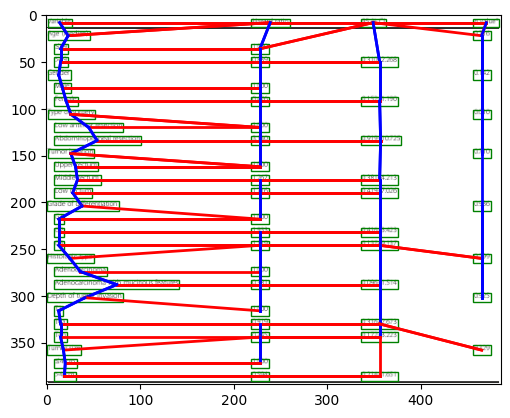

In [2]:
import json
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# Constants for classes
CLASS_NONE = 0
CLASS_HORZ = 1
CLASS_VERT = 2

# Sample paths
jsonl_path = r'C:\Users\remote desktop\Downloads\DETR-GFTE\datasets\gnet_train.jsonl'
image_directory = r'C:\Users\remote desktop\Downloads\pubtabnet\train'

# Step 1: Read the first line from the JSONL file
with open(jsonl_path, 'r', encoding='utf8') as f:
    first_line = f.readline()
    label = json.loads(first_line)

# Step 2: Retrieve the image from the filename
filename = label['filename']
image_path = image_directory + '\\'+  filename
image = Image.open(image_path)

# Step 3: Convert "bboxes" and "orig_size" to tensors with dtype int
bboxes = torch.tensor(label['bboxes'], dtype=torch.int)
orig_size = torch.tensor([label['orig_size']['width'], label['orig_size']['height']], dtype=torch.int)

probs, edge_index = model(bboxes, orig_size)
probs, edge_index = probs.to('cpu'), edge_index.to('cpu')

# Step 5: Plotting the bboxes and edges, coloring by predicted class
fig, ax = plt.subplots(1)
ax.imshow(image)

# Plot the bounding boxes
for bbox in bboxes:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Plot the edges
for i, (start, end) in enumerate(edge_index.t()):
    # Get the centers of the start and end bboxes
    bbox1 = bboxes[start]
    bbox2 = bboxes[end]
    
    x1, y1 = bbox1[0] + bbox1[2] // 2, bbox1[1] + bbox1[3] // 2
    x2, y2 = bbox2[0] + bbox2[2] // 2, bbox2[1] + bbox2[3] // 2
    
    # Get the predicted class for the edge
    predicted_class = torch.argmax(probs[i]).item()
    
    # Set the color based on predicted class
    if predicted_class == CLASS_HORZ:
        color = 'red'
    elif predicted_class == CLASS_VERT:
        color = 'blue'
    else:
        color = 'transparent'
    
    if color != 'transparent':  # Only plot if the edge is not class 0
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

plt.show()
